In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bottleneck as bn
import scipy as sc

In [2]:
file_path = "wallcharge.lammpstrj"
charges = []
positions = []
# Read the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Flag to indicate if we are in the ATOMS section
in_atoms_section = False
n_atoms = int(lines[3])

# Loop through each line in the file
for line in lines:
    # Check if the line starts with "ITEM: ATOMS"
    if line.startswith("ITEM: ATOMS"):
        in_atoms_section = True
        continue
    
    # If in the ATOMS section, extract the charge
    if in_atoms_section:
        if line.startswith("ITEM:"):  # If a new ITEM section starts, stop reading ATOMS
            in_atoms_section = False
        # Split the line by spaces and get the charge (last element)
        else:
            type = int(line.split()[1])
            charge = float(line.split()[-1])
            pos = np.array([float(x) for x in line.split()[2:5]])
            charges.append([charge,type])
            positions.append(pos)

# Print the extracted charges
charges=np.array(charges)
positions = np.array(positions)
charges =np.array([charges[i:i+n_atoms] for i in range(0, len(charges), n_atoms)])
positions =np.array([positions[i:i+n_atoms] for i in range(0, len(positions), n_atoms)])
type = {1:"bottom wall", 2:"O", 3: "H",4:"Na", 5:"Cl", 6: "top wall"}  


In [15]:
list = []
for i in range(np.shape(charges)[0]):
    ind_top = charges[i,:,1]==1
    ind_bottom = charges[i,:,1]==6
    ind_O = charges[i,:,1]==2
    ind_H = charges[i,:,1]==3
    ind_Na = charges[i,:,1]==4
    ind_Cl = charges[i,:,1]==5

    charges_top = charges[i,ind_top,:]
    charges_bottom = charges[i,ind_bottom,:]
    pos_top = positions[i,ind_top,:]
    charges_O = charges[i,ind_O,:]
    charges_H = charges[i,ind_H,:]
    charges_Na = charges[i,ind_Na,:]
    charges_Cl = charges[i,ind_Cl,:]

    position_O = positions[i,ind_O,:]
    position_H = positions[i,ind_H,:]
    position_Na = positions[i,ind_Na,:]
    position_Cl = positions[i,ind_Cl,:]
    dipole_O = np.sum(np.dot(charges_O[0,0],position_O),axis=0)
    dipole_H = np.sum(np.dot(charges_H[0,0],position_H),axis=0)
    dipole_Na = np.sum(np.dot(charges_Na[0,0],position_Na),axis=0)
    dipole_Cl = np.sum(np.dot(charges_Cl[0,0],position_Cl),axis=0)

    list.append([np.sum(charges_top[:,0]),np.sum(charges_bottom[:,0]),dipole_O,dipole_H,dipole_Na,dipole_Cl,charges_top[:,0],pos_top])    
# list = np.array(list)


(-1.0, 10.0)

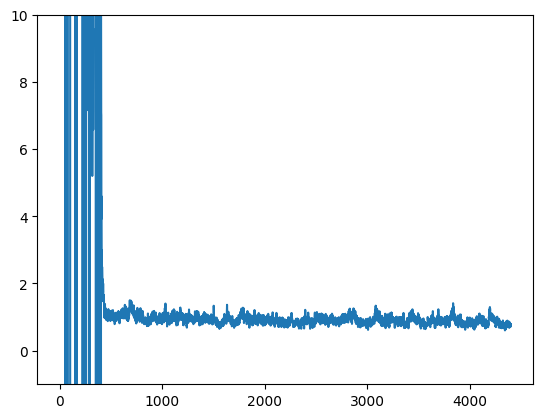

In [22]:
charges_top = [list[i][-2] for i in range(len(list))]
pos_top = [list[i][-1] for i in range(len(list))]
charges_top = np.array(charges_top)
pos_top = np.array(pos_top)[:,:,:2]

charges_std = np.std(charges_top,axis=1)
plt.plot(charges_std/np.mean(charges_top,axis=1))
plt.ylim(-1,10)

/tmp/ipykernel_948334/544331050.py:11: RuntimeWarning: overflow encountered in exp
  return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty


tau_water = 0.05006508126674661, tau_ions = 20.51832368309644, Q_infty = 4.146448749539516, t_delay = 249.33745180919283, A = 2.275187066866133e-05


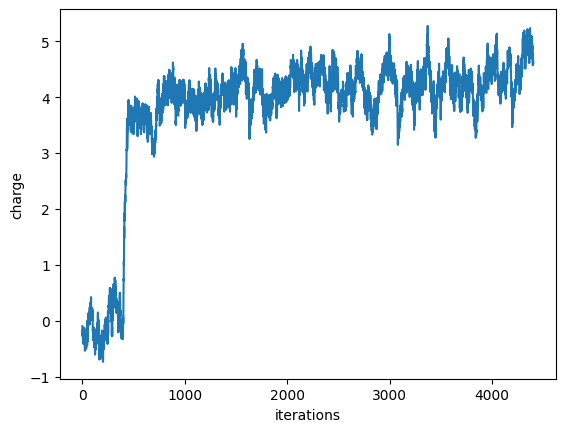

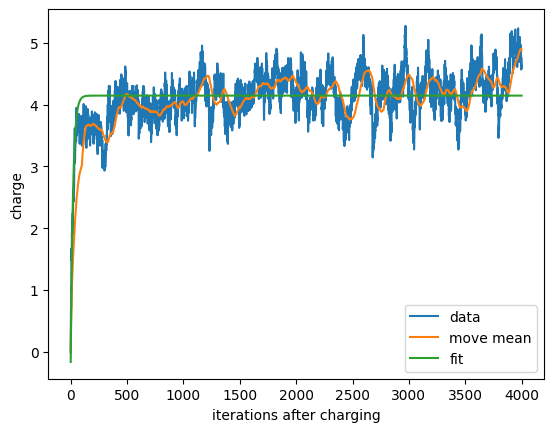

In [5]:
plt.plot([list[i][0] for i in range(len(list))])
plt.xlabel("iterations")
plt.ylabel("charge")
plt.savefig("charge_top_wall_full.png")
plt.figure()
start = [list[i][0] for i in range(400,len(list))]
# start = list[400:,0]
plt.plot(start, label='data')
plt.plot(bn.move_mean(start, window=100, min_count=1), label='move mean')
def exponential_fit(t,tau_water,tau_ions,Q_infty,t_delay,A):
    return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty

params = sc.optimize.curve_fit(exponential_fit, np.arange(len(start)), start, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
plt.plot(np.arange(len(start)), exponential_fit(np.arange(len(start)), *params[0]), label='fit')
plt.xlabel("iterations after charging")
plt.ylabel("charge")
plt.legend()
plt.savefig("charge_top_wall_with_fit.png")
print(f"tau_water = {params[0][0]}, tau_ions = {params[0][1]}, Q_infty = {params[0][2]}, t_delay = {params[0][3]}, A = {params[0][4]}")
# plt.title("charge on the top wall")
# plt.ylim(-1,1)

/tmp/ipykernel_948334/3525269461.py:16: RuntimeWarning: overflow encountered in exp
  return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty
/tmp/ipykernel_948334/3525269461.py:16: RuntimeWarning: overflow encountered in multiply
  return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty
/tmp/ipykernel_948334/3525269461.py:18: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-(t-t_delay)/tau)+Q_infty
/tmp/ipykernel_948334/3525269461.py:18: RuntimeWarning: overflow encountered in multiply
  return A*np.exp(-(t-t_delay)/tau)+Q_infty


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

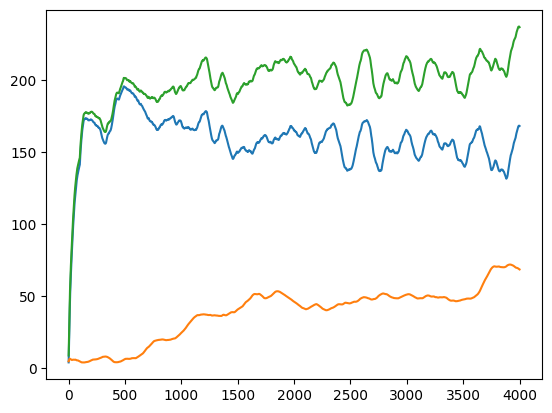

In [6]:
dipole_water = []
dipole_ions = []
dipole_solutes = []
for t in range(400,len(list)):
    dipole_water.append(np.linalg.norm(list[t][2][2]+list[t][3][2]))
    dipole_ions.append(np.linalg.norm(list[t][4][2]+list[t][5][2]))
    dipole_solutes.append(np.linalg.norm(list[t][4][2]+list[t][5][2]+list[t][2][2]+list[t][3][2]))
# plt.plot(dipole_water, label='water')
plt.plot(bn.move_mean(dipole_water, window=100, min_count=1), label='smoothed water')
# plt.plot(dipole_ions, label='ions')
plt.plot(bn.move_mean(dipole_ions, window=100, min_count=1), label='smoothed ions')
# plt.plot(dipole_solutes, label='solutes')
plt.plot(bn.move_mean(dipole_solutes, window=100, min_count=1), label='smoothed solutes')

def exponential_fit(t,tau_water,tau_ions,Q_infty,t_delay,A):
    return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty
def single_exponential(t,tau,Q_infty,A,t_delay):
    return A*np.exp(-(t-t_delay)/tau)+Q_infty
params_solute = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_solutes)), dipole_solutes, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
# params_water = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_water)), dipole_water, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
# params_ions = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_ions)), dipole_ions, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
params_solute_single = sc.optimize.curve_fit(single_exponential, np.arange(len(dipole_solutes)), dipole_solutes, maxfev=10000, method="dogbox", p0=[10,5,1,10])
params_water_single = sc.optimize.curve_fit(single_exponential, np.arange(len(dipole_water)), dipole_water, maxfev=10000, method="dogbox", p0=[10,5,1,10])
params_ions_single = sc.optimize.curve_fit(single_exponential, np.arange(len(dipole_ions)), dipole_ions, maxfev=10000, method="dogbox", p0=[10,5,1,10])
                                           

plt.plot(np.arange(len(dipole_solutes)), exponential_fit(np.arange(len(dipole_solutes)), *params_solute[0]), label='fit solutes')

# plt.plot(np.arange(len(dipole_solutes)), single_exponential(np.arange(len(dipole_solutes)), *params_solute_single[0]), label='fit solutes single')
plt.plot(np.arange(len(dipole_water)), single_exponential(np.arange(len(dipole_water)), *params_water_single[0]), label='fit water single')
plt.plot(np.arange(len(dipole_ions)), single_exponential(np.arange(len(dipole_ions)), *params_ions_single[0]), label='fit ions single')
plt.xlabel("iterations after charging")
plt.ylabel("magnitude of dipole moment")

print(f"BOTH: tau_water = {params_solute[0][0]}, tau_ions = {params_solute[0][1]}, Q_infty = {params_solute[0][2]}, t_delay = {params_solute[0][3]}, A = {params_solute[0][4]}")
print(f"BoTH SINGLE: tau = {params_solute_single[0][0]}, Q_infty = {params_solute_single[0][1]}, A = {params_solute_single[0][2]}, t_delay = {params_solute_single[0][3]}")
print(f"WATER SINGLE: tau = {params_water_single[0][0]}, Q_infty = {params_water_single[0][1]}, A = {params_water_single[0][2]}, t_delay = {params_water_single[0][3]}")
print(f"IONS SINGLE: tau = {params_ions_single[0][0]}, Q_infty = {params_ions_single[0][1]}, A = {params_ions_single[0][2]}, t_delay = {params_ions_single[0][3]}")
plt.legend()